_This project was developed independently as part of Code Institute’s Predictive Analytics Project. Any datasets or templates used are openly provided by the course or via public sources like Kaggle. All commentary and code logic are my own._

# Notebook 04: Price Analysis

## Objective

- This notebook dives into exploratory data analysis (EDA) focused specifically on the **Sale Price** of properties.  
- We'll analyze patterns, transformations, and outliers — and extract actionable insights to guide model building.

## Change Working Directory
- Since it is expected that you would keep the notebooks in a subfolder, you will need to switch the working directory when you run the notebook in the editor.
- The working directory must be changed from its current folder to its parent folder.
- We wish to change the current directory's parent to the new current directory.
- Verify the updated current directory.

In [3]:
# Smart Working Directory Setup
import os
project_root = '/workspaces/heritage_housing'
if os.getcwd() != project_root:
    try:
        os.chdir(project_root)
        print(f"[INFO] Changed working directory to project root: {os.getcwd()}")
    except FileNotFoundError:
        raise FileNotFoundError(f"[ERROR] Project root '{project_root}' not found!")

[INFO] Changed working directory to project root: /workspaces/heritage_housing


### Load Libraries
- Load libraries
- Load cleaned data from /data/processed/df_cleaned.csv

In [4]:
# Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
%matplotlib inline

# Load the Cleaned Data
df = pd.read_csv("data/processed/df_cleaned.csv")

# Review column names
df.columns


Index(['1stflrsf', '2ndflrsf', 'bedroomabvgr', 'bsmtexposure', 'bsmtfinsf1',
       'bsmtfintype1', 'bsmtunfsf', 'garagearea', 'garagefinish',
       'garageyrblt', 'grlivarea', 'kitchenqual', 'lotarea', 'lotfrontage',
       'masvnrarea', 'openporchsf', 'overallcond', 'overallqual',
       'totalbsmtsf', 'yearbuilt', 'yearremodadd', 'saleprice'],
      dtype='object')

## Sale Price Distribution

In this section, we examine the distribution of the target variable — `SalePrice`. This will help us understand whether the data is skewed, if log transformation is needed, and whether any outliers are visibly affecting the distribution.

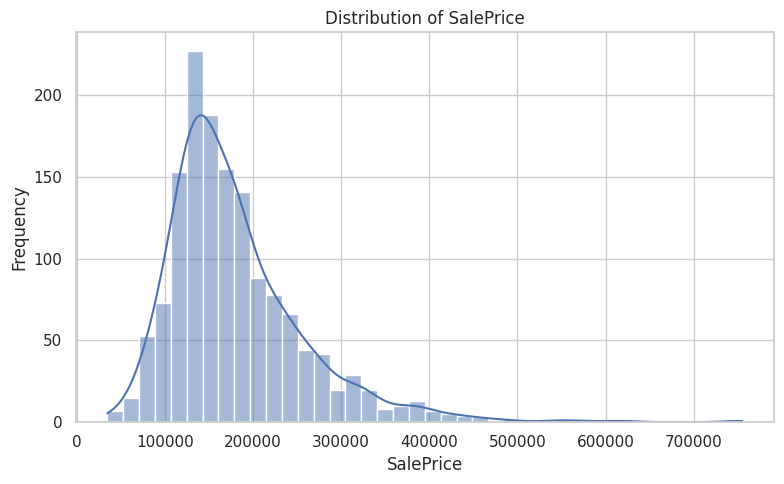

In [6]:
# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['saleprice'], kde=True, bins=40)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### Observations:
- The distribution of `saleprice` is right-skewed.
- This skewness may affect model performance due to the violation of linear model assumptions.
- A log transformation will likely help normalize the target.

## Skewness & Kurtosis Analysis

Before applying transformations, we quantify how skewed and peaked the distribution is using statistical metrics.

In [8]:
from scipy.stats import skew, kurtosis

price = df['saleprice']
print(f"Skewness: {skew(price):.2f}")
print(f"Kurtosis: {kurtosis(price):.2f}")

Skewness: 1.88
Kurtosis: 6.51


### Log-Transformed Target

We'll log-transform `saleprice` using `log1p` and re-plot the distribution to check normalization.

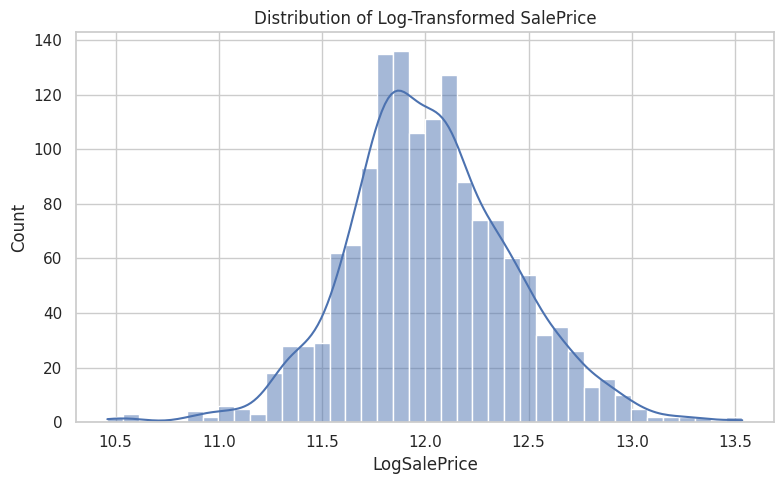

New Skewness: 0.12
New Kurtosis: 0.80


In [9]:
df['LogSalePrice'] = np.log1p(df['saleprice'])

# Plot new distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['LogSalePrice'], kde=True, bins=40)
plt.title("Distribution of Log-Transformed SalePrice")
plt.xlabel("LogSalePrice")
plt.tight_layout()
plt.show()

# Re-check skewness
print(f"New Skewness: {skew(df['LogSalePrice']):.2f}")
print(f"New Kurtosis: {kurtosis(df['LogSalePrice']):.2f}")

### Updated Skewness Analysis (After Log Transformation)

The log-transformed distribution of `saleprice` is significantly more symmetrical compared to the original. The KDE curve aligns well with a normal distribution shape, indicating:
- **Reduced skewness** — the long right tail is now compressed.
- **Improved model readiness** — this transformation will support better assumptions for linear models.
- Outliers are still visible but now less influential in magnitude.

We will use `LogSalePrice` as the target for further analysis and modeling.

## Correlation Analysis

To identify features that have the strongest relationship with house prices, we'll compute Pearson correlation coefficients between all numerical variables and `LogSalePrice`.

This will help in:
- Selecting features for modeling
- Prioritizing further investigation in the next steps

Top 20 Correlated Features with LogSalePrice:
LogSalePrice    1.000000
saleprice       0.948374
overallqual     0.817185
grlivarea       0.700927
garagearea      0.650888
totalbsmtsf     0.612134
1stflrsf        0.596981
yearbuilt       0.586570
yearremodadd    0.565608
masvnrarea      0.426776
bsmtfinsf1      0.372023
garageyrblt     0.349013
lotfrontage     0.335292
openporchsf     0.321053
2ndflrsf        0.311887
lotarea         0.257320
bsmtunfsf       0.221985
bedroomabvgr    0.123774
overallcond    -0.036868
Name: LogSalePrice, dtype: float64


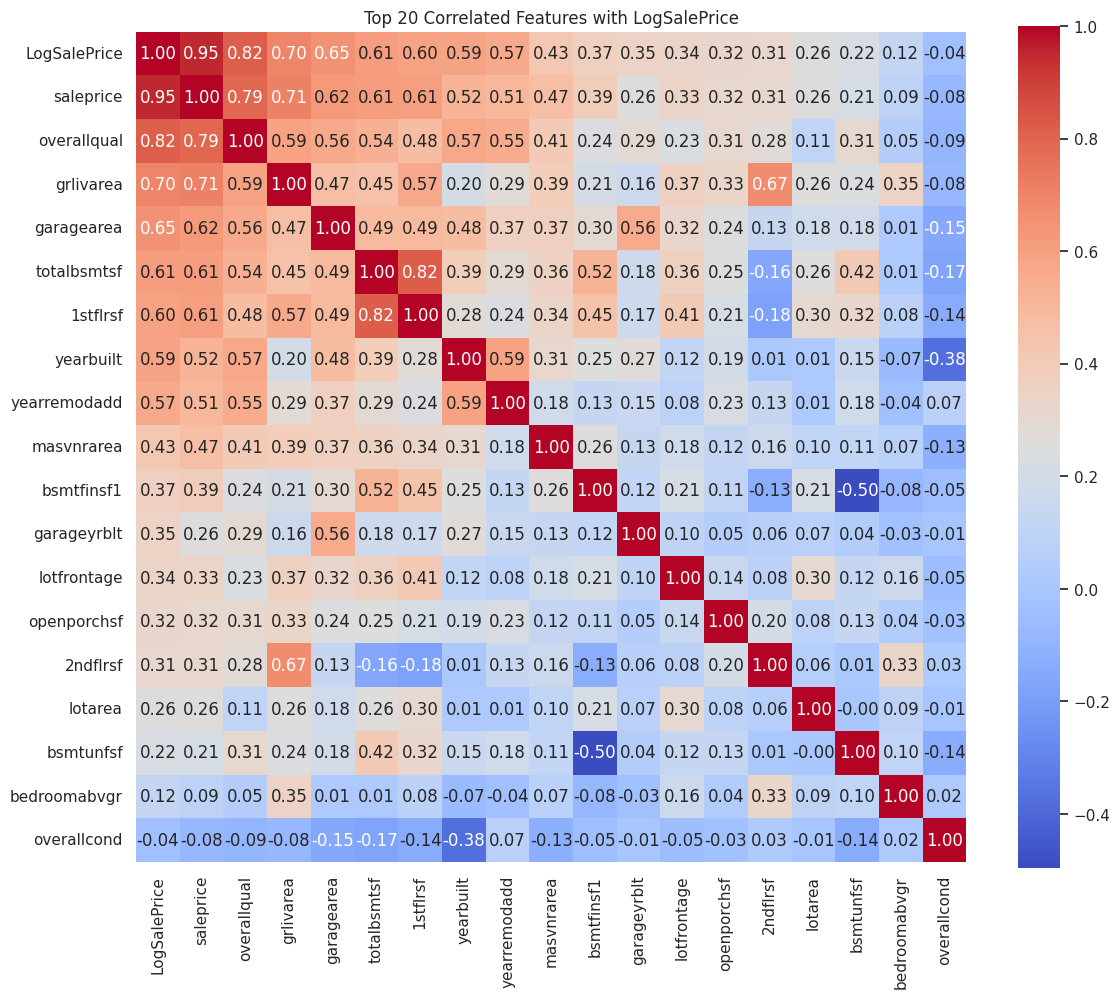

In [10]:
# Compute correlation matrix with LogSalePrice
corr_matrix = df.corr(numeric_only=True)
top_corr = corr_matrix['LogSalePrice'].sort_values(ascending=False).head(20)

# Display top 20 correlated features
print("Top 20 Correlated Features with LogSalePrice:")
print(top_corr)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df[top_corr.index].corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Top 20 Correlated Features with LogSalePrice")
plt.tight_layout()
plt.show()

#### Heatmap Insights:

Based on the correlation heatmap with LogSalePrice, the following key insights emerge:

**Top Drivers:**
- OverallQual (0.82) is the strongest positive correlation with LogSalePrice, indicating build quality is a top price determinant.
- GrLivArea (0.70) also has a strong correlation, confirming above-ground living space heavily influences sale prices.
- GarageArea (0.65), TotalBsmtSF (0.61), and 1stFlrSF (0.60) follow as solid predictors, reinforcing that overall usable square footage (above and below ground) is critical.

**Time Features:**
- YearBuilt (0.59) and YearRemodAdd (0.57) suggest that newer or recently renovated homes are more valuable, but with slightly less influence than size or quality.
- Mid-tier Correlators:
- MasVnrArea (0.43) and BsmtFinSF1 (0.37) show moderate influence — these may become more important in nonlinear models.

**Low Correlation Feature:**
- GarageYrBlt, LotFrontage, OpenPorchSF, and 2ndFlrSF have lower correlations (< 0.35) and may not individually carry much weight in predictive models.
- However, they shouldn't be dropped outright — their impact may emerge in interactions or tree-based models.


#### Scatterplots – Numerical Features vs LogSalePrice

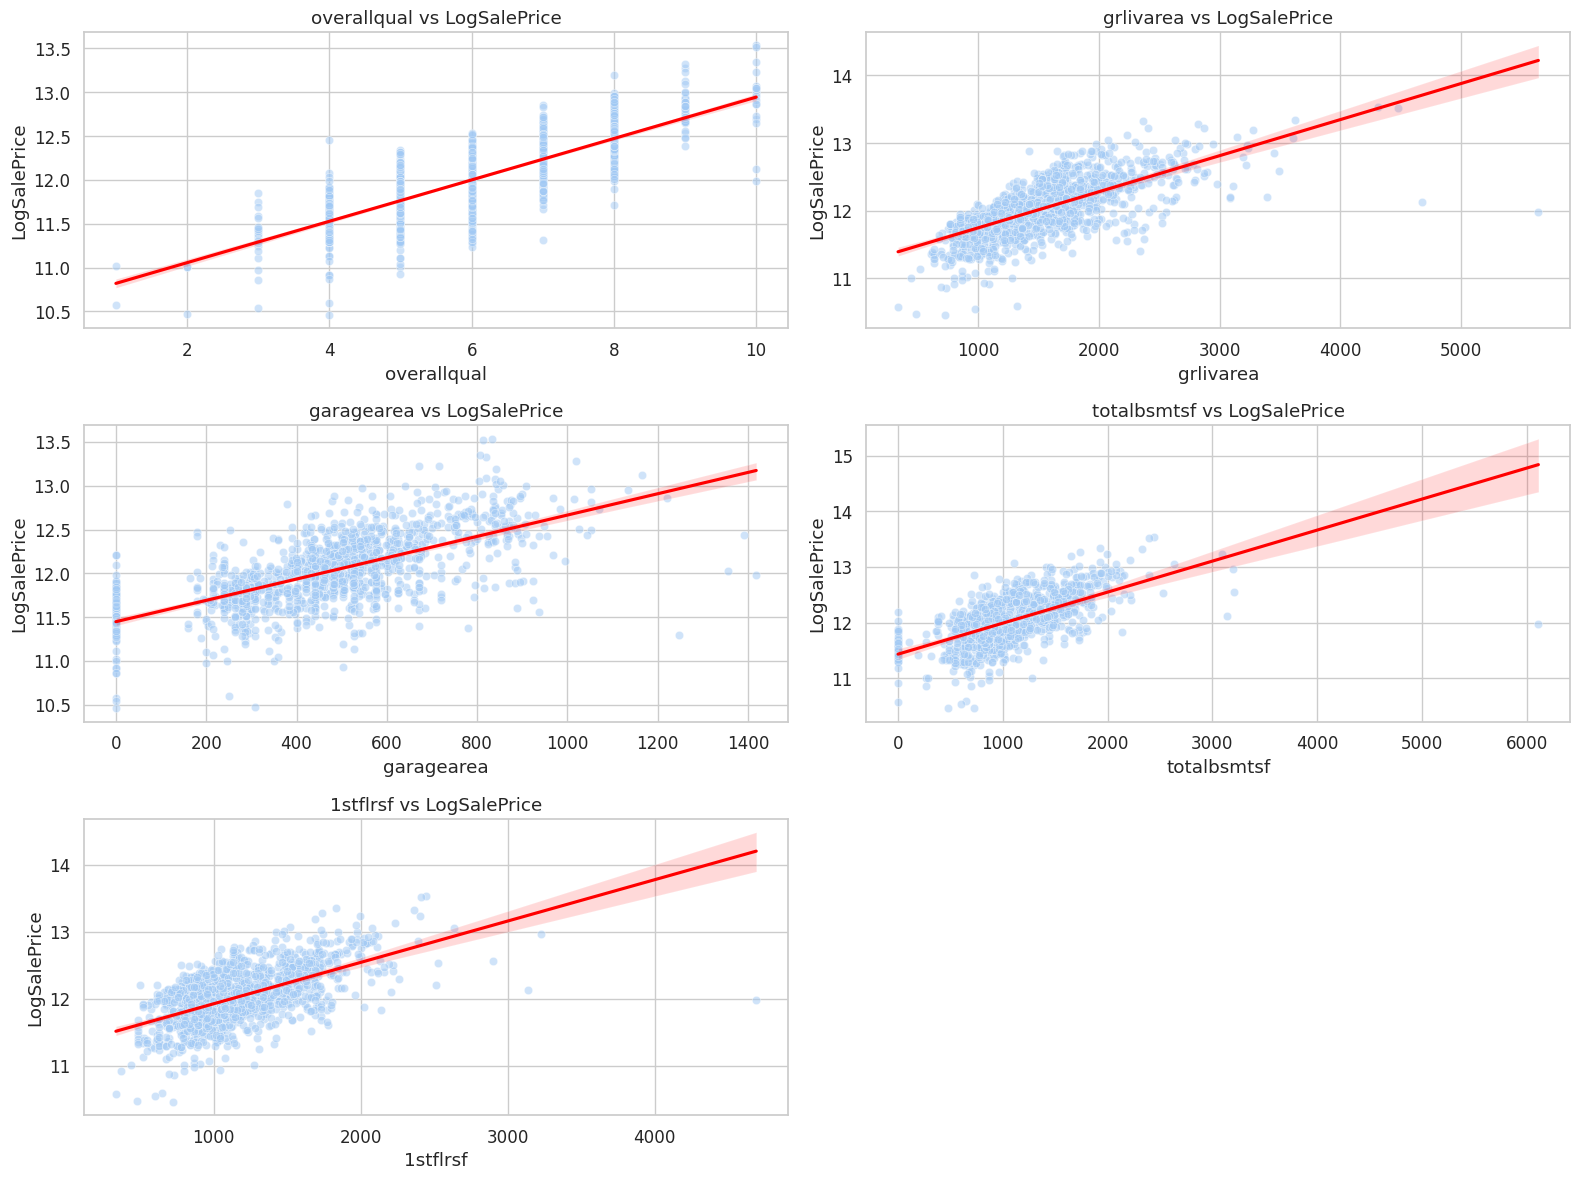

In [17]:
# Define top numerical features for scatterplots
scatter_features = ['overallqual', 'grlivarea', 'garagearea', 'totalbsmtsf', '1stflrsf']

# Plot scatterplots
plt.figure(figsize=(16, 12))
for i, feature in enumerate(scatter_features):
    plt.subplot(3, 2, i + 1)
    sns.scatterplot(data=df, x=feature, y='LogSalePrice', alpha=0.5)
    sns.regplot(data=df, x=feature, y='LogSalePrice', scatter=False, color='red')
    plt.title(f'{feature} vs LogSalePrice')
plt.tight_layout()
plt.show()


## Key Feature Relationships

The goal is to visualize how the most correlated numerical features interact with `LogSalePrice`. This helps confirm:
- Linearity or non-linearity in relationships
- Outliers and heteroscedasticity
- Whether transformations or binning may be needed

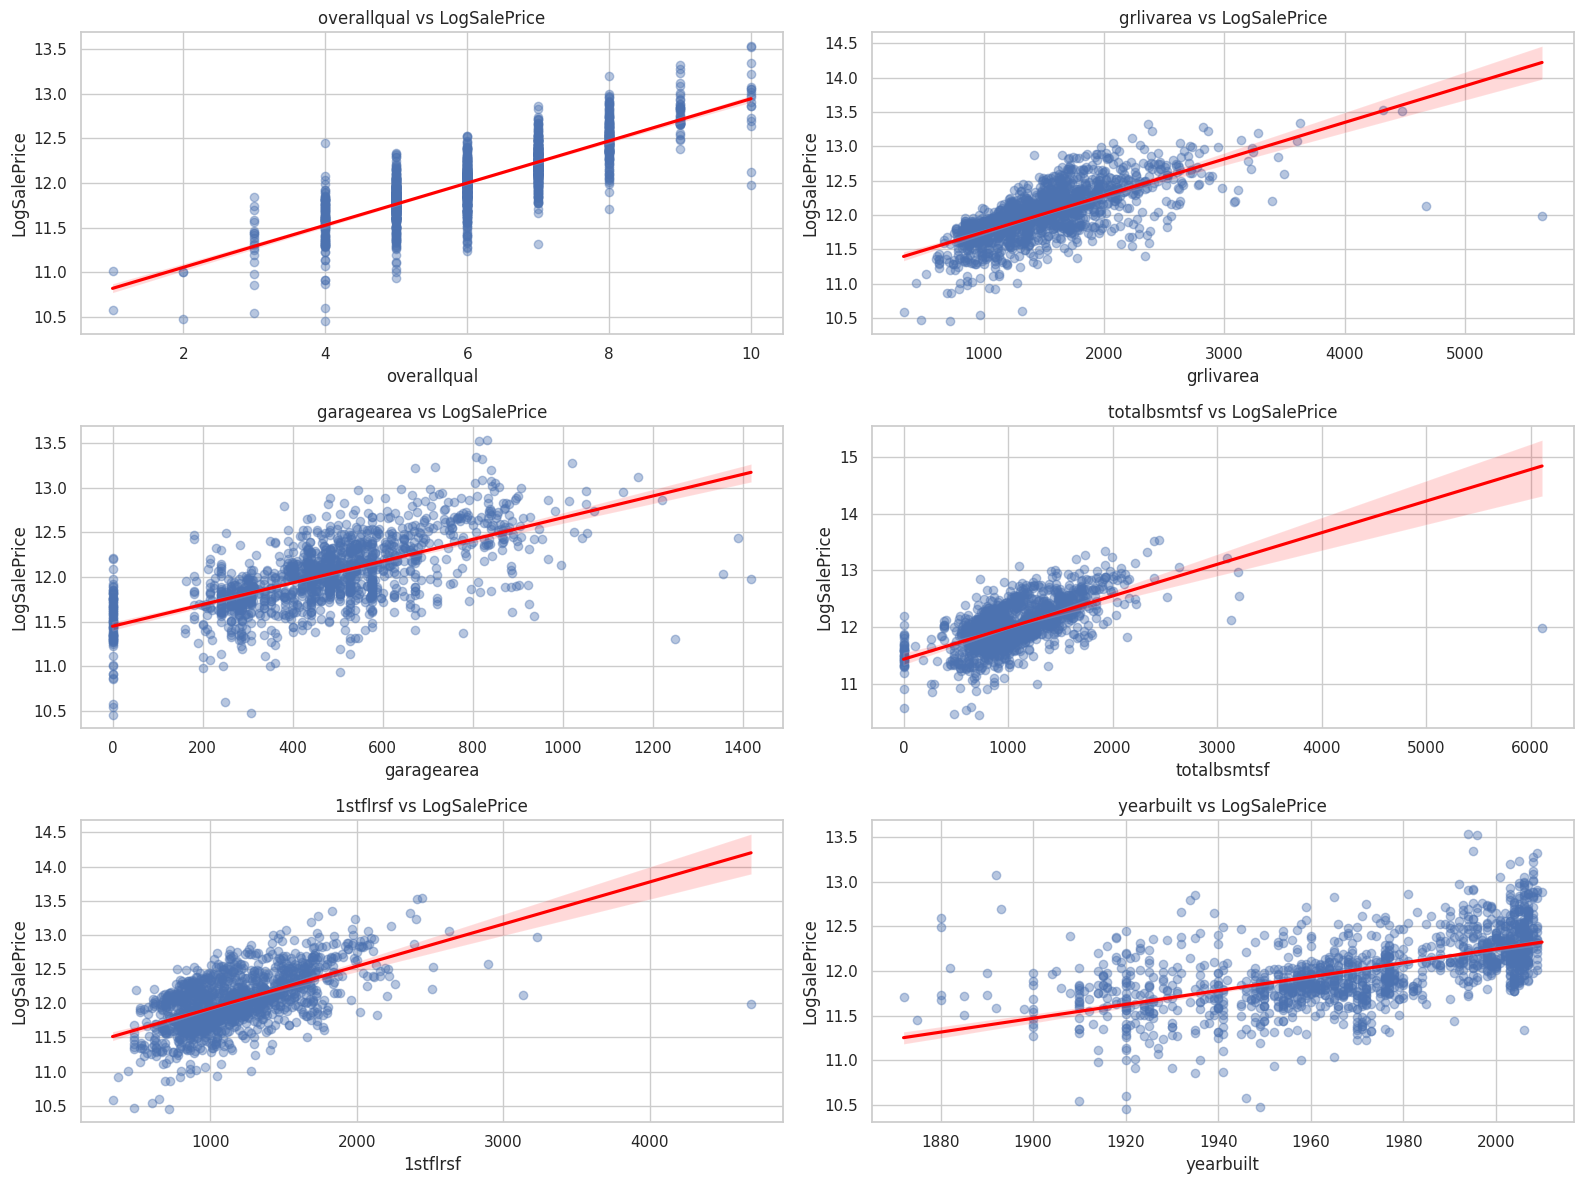

In [ ]:
# Define top features 
top_features = ['overallqual', 'grlivarea', 'garagearea', 'totalbsmtsf', '1stflrsf', 'yearbuilt']

plt.figure(figsize=(16, 12))
for i, feature in enumerate(top_features):
    plt.subplot(3, 2, i+1)
    sns.regplot(x=df[feature], y=df['LogSalePrice'], scatter_kws={"alpha":0.4}, line_kws={"color":"red"})
    plt.title(f'{feature} vs LogSalePrice')
    plt.xlabel(feature)
    plt.ylabel('LogSalePrice')

plt.tight_layout()
plt.show()

### 🔍 Observations:
- `overallqual` shows the strongest positive correlation with `LogSalePrice`. As overall material and finish quality improves, so does the house price — no surprises here. It's a power feature.
- `grlivarea` (Above ground living area) also has a strong linear relationship with `LogSalePrice`. Larger living spaces are highly valued by buyers.
- `garagearea` correlates positively, but we observe diminishing returns — after a certain size, the impact flattens. It may capture both usable parking and "bonus" storage, but not always price-driving.
- `totalbsmtsf` and `1stflrSf` display upward trends, but with more noise. Basement size is impactful only when it's finished or usable.
- `yearbuilt` has a positive trend — newer homes tend to command higher prices — though this is moderated by neighborhood trends and renovations.

**Key Takeaway:** 

These features are likely to be important in model training, and are strong candidates for scaling, interaction terms, or polynomial features later on.



## Target Variable Analysis

#### Objective:

**Distribution of Target Variable (SalePrice)**

- Histogram + KDE plot (pre- and post-log transformation)
- Show that raw SalePrice is right-skewed
- Log-transformation brings it close to normal

**Why are we doing this?**

To justify log-transforming the target and verify it's more model-friendly.

### Skewness & Kurtosis Before and After
Quantify how skewed the original and transformed variable is:

In [19]:
from scipy.stats import skew, kurtosis
skew(df['saleprice']), kurtosis(df['saleprice'])
skew(df['LogSalePrice']), kurtosis(df['LogSalePrice'])


(0.12122191311528058, 0.802642710746805)

Done to statistically confirm what the plots suggest — better distribution.
